In [2]:
import tensorflow as tf
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

/device:GPU:0
Num GPUs Available:  1


In [1]:
!pip install tf-nightly

     |████████████████████████████████| 396.1MB 45kB/s 
     |████████████████████████████████| 14.5MB 245kB/s 
     |████████████████████████████████| 1.3MB 39.0MB/s 
     |████████████████████████████████| 10.6MB 32.8MB/s 
     |████████████████████████████████| 471kB 38.7MB/s 
     |████████████████████████████████| 3.8MB 33.1MB/s 
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4
  Found existing installation: grpcio 1.33.2
    Uninstalling grpcio-1.33

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub


In [6]:
path = "/content/drive/My Drive/plant diseases detection"
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'test')

BATCH_SIZE = 32
IMG_SIZE = (256,256)

train_dataset = image_dataset_from_directory(train_dir,labels='inferred',label_mode='int',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.15,
                                             subset='training',seed=42)

validation_dataset = image_dataset_from_directory(train_dir,labels='inferred',label_mode='int',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,validation_split=0.15,subset='validation',seed=150)

Found 2347 files belonging to 28 classes.
Using 1995 files for training.
Found 2347 files belonging to 28 classes.
Using 352 files for validation.


In [7]:
class_names = train_dataset.class_names
print(class_names)


['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'Tomato two spotted spider mites leaf', 'grape leaf', 'grape leaf black rot']


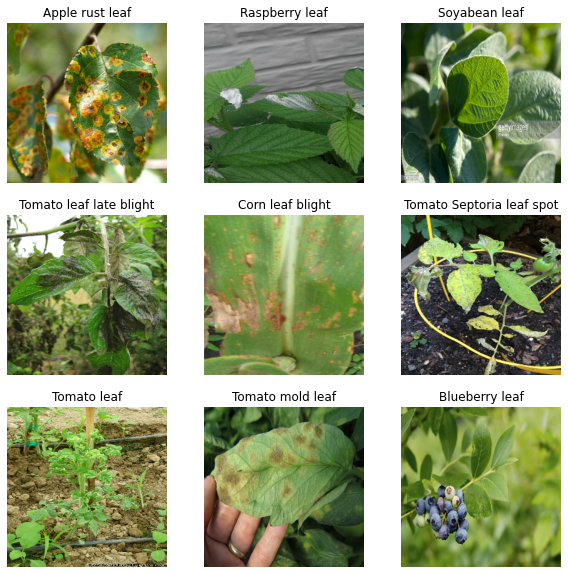

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 256, 256, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
base_model=tf.keras.applications.DenseNet121(weights= 'imagenet', include_top=False, input_shape= (256,256,3))
base_model.trainable = False
output = base_model.layers[-1].output
output = tf.keras.layers.Flatten()(output)
Resnet= tf.keras.Model(inputs=base_model.input, outputs = output)

model= tf.keras.models.Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256,256, 3)))
model.add(Resnet)
#model.add(GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(len(class_names),activation='softmax'))

29089792/29084464 [==============================] - 1s 0us/step


In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [12]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
functional_1 (Functional)    (None, 65536)             7037504   
_________________________________________________________________
dropout (Dropout)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 28)                1835036   
Total params: 8,872,540
Trainable params: 1,835,036
Non-trainable params: 7,037,504
_________________________________________________________________


In [13]:
epochs=400
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/400
63/63 [==============================] - 53s 843ms/step - loss: 3.3088 - accuracy: 0.0757 - val_loss: 3.2788 - val_accuracy: 0.1108
Epoch 2/400
63/63 [==============================] - 18s 288ms/step - loss: 3.2249 - accuracy: 0.1865 - val_loss: 3.2120 - val_accuracy: 0.1875
Epoch 3/400
63/63 [==============================] - 18s 287ms/step - loss: 3.1618 - accuracy: 0.2642 - val_loss: 3.1555 - val_accuracy: 0.2670
Epoch 4/400
63/63 [==============================] - 18s 286ms/step - loss: 3.1073 - accuracy: 0.3278 - val_loss: 3.0985 - val_accuracy: 0.3551
Epoch 5/400
63/63 [==============================] - 18s 286ms/step - loss: 3.0586 - accuracy: 0.3930 - val_loss: 3.0529 - val_accuracy: 0.4091
Epoch 6/400
63/63 [==============================] - 18s 286ms/step - loss: 3.0181 - accuracy: 0.4241 - val_loss: 3.0108 - val_accuracy: 0.4347
Epoch 7/400
63/63 [==============================] - 18s 286ms/step - loss: 2.9737 - accuracy: 0.4722 - val_loss: 2.9780 - val_accuracy:

In [14]:
model.save(path+'/saved_model_mod') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/plant diseases detection/saved_model_mod/assets


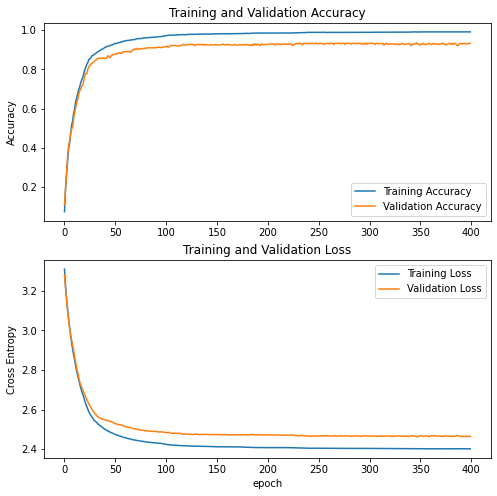

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()